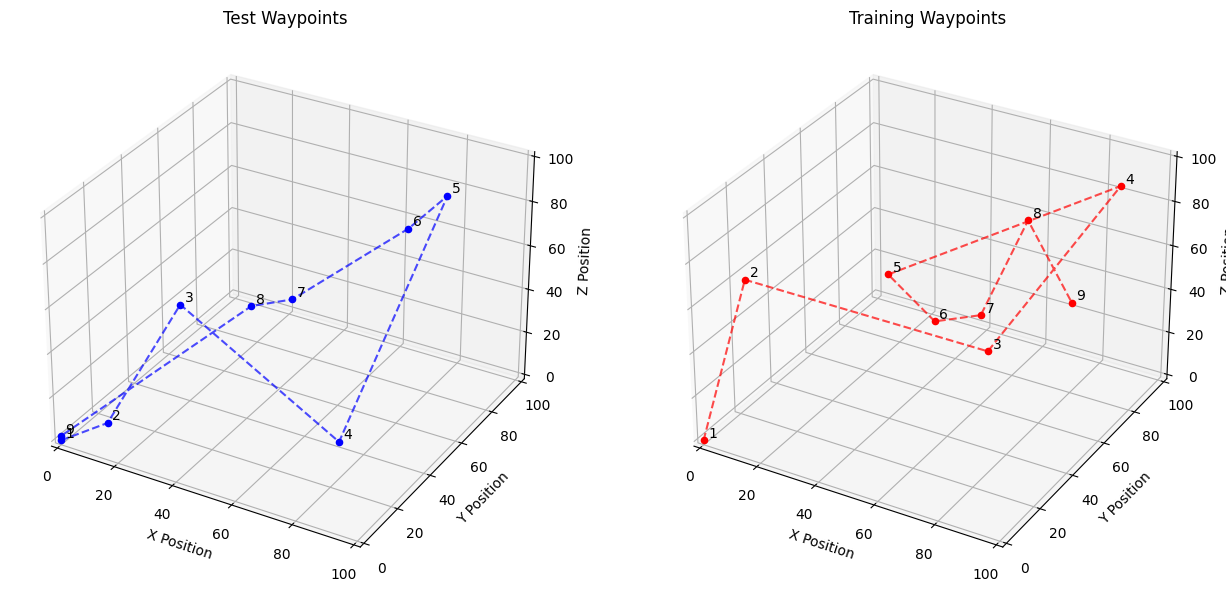

In [ ]:
from main import *
from matplotlib import pyplot as plt

"""
Run the drone simulation and plot the results.
"""
# Load configuration parameters
parameters = load_parameters('Settings/simulation_parameters.yaml')

# # --- Define Waypoints (with desired speed) ---
# Challenging waypoint set: sharp turns, altitude swings, varying speeds, backtracking and a hover loiter
waypoints = [
    {'x': 0.0,  'y': 0.0,  'z': 0.0,   'v': 5},   # Start point
    {'x': 10.0,  'y': 10.0,  'z': 5.0,   'v': 5},   # Takeoff and initial climb
    {'x': 30.0,  'y': 20.0,  'z': 60.0,  'v': 5},   # Aggressive climb + diagonal
    {'x': 80.0,  'y': 25.0,  'z': 15.0,  'v': 5},   # Fast descent and forward punch
    {'x': 85.0,  'y': 80.0,  'z': 90.0,  'v': 5},   # Tall vertical rise after lateral shift
    {'x': 75.0,  'y': 75.0,  'z': 75.0,  'v': 5},   # Accelerated 3D diagonal
    {'x': 50.0,  'y': 50.0,  'z': 50.0,  'v': 5},   # Slow hover (loiter) point
    {'x': 15.0,  'y': 85.0,  'z': 10.0,  'v': 5},   # Backtrack low
    {'x': 0.0,   'y': 0.0,   'z': 2.0,   'v': 5}    # Final descent and landing
]
train_waypoints = create_training_waypoints()
train_waypoints.insert(0, waypoints[0])  # Ensure starting point is included
del train_waypoints[len(train_waypoints)-1]  # Remove last point to avoid duplication with original waypoints

# Plot both waypoints sets in a 3D map, from top, side by side. An increasing counter shows the waypoint number between start (A) and finish (B), where A is 0,0,0
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(13, 6))
axs = [fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')]

# Plot original waypoints
axs[0].set_title("Test Waypoints")
axs[0].set_xlabel("X Position")
axs[0].set_ylabel("Y Position")
axs[0].set_zlabel("Z Position")
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 100)
axs[0].set_zlim(0, 100)
x_vals = [wp['x'] for wp in waypoints]
y_vals = [wp['y'] for wp in waypoints]
z_vals = [wp['z'] for wp in waypoints]
axs[0].plot(x_vals, y_vals, z_vals, 'b--', alpha=0.7)  # Dashed line for trajectory
for i, wp in enumerate(waypoints):
    axs[0].scatter(wp['x'], wp['y'], wp['z'], c='b')
    axs[0].text(wp['x']+1, wp['y']+1, wp['z']+1, f"{i+1}", fontsize=10)

# Plot training waypoints
axs[1].set_title("Training Waypoints")
axs[1].set_xlabel("X Position")
axs[1].set_ylabel("Y Position")
axs[1].set_zlabel("Z Position")
axs[1].set_xlim(0, 100)
axs[1].set_ylim(0, 100)
axs[1].set_zlim(0, 100)
x_vals_train = [wp['x'] for wp in train_waypoints]
y_vals_train = [wp['y'] for wp in train_waypoints]
z_vals_train = [wp['z'] for wp in train_waypoints]
axs[1].plot(x_vals_train, y_vals_train, z_vals_train, 'r--', alpha=0.7)  # Dashed line for trajectory
for i, wp in enumerate(train_waypoints):
    axs[1].scatter(wp['x'], wp['y'], wp['z'], c='r')
    axs[1].text(wp['x']+1, wp['y']+1, wp['z']+1, f"{i+1}", fontsize=10)

plt.tight_layout()
plt.savefig("Plots/waypoints_comparison.png", dpi=300)
plt.show()


In [54]:
# Create random waypoints
# waypoints = create_random_waypoints(n=2, x_range=(10, 90), y_range=(10, 90), z_range=(10, 100), v=5)
# Initial drone state
init_state = create_initial_state()

# Get maximum thrust from the rotor model
thrust_max = get_max_thrust_from_rotor_model(parameters)


manual_pid_gains = {
    "k_pid_yaw": [0.5, 1e-6, 0.1],
    "k_pid_pos": [0.7, 0.01, 0.09],
    "k_pid_alt": [0.7, 0, 0.1],
    "k_pid_att": [20, 1, 0.01],
    "k_pid_hsp": [1, 0.01, 0.01],
    "k_pid_vsp": [150, 10, 1]
}

optimized_gwo_pid_gains = {
    "k_pid_pos": [0.5912360748861284, 0.006228451250902666, 0.0005196818571338917],
    "k_pid_alt": [1.4060343981877192, 0.004390991108908305, 0.008616530514507196],
    "k_pid_att": [47.85278324313231, 0.3039716476667375, 0.937725783178275],
    "k_pid_yaw": [0.5, 1e-06, 0.1],
    "k_pid_hsp": [0.0958432558726718, 0.008471735616404054, 0.0],
    "k_pid_vsp": [120.3598201262903, 148.59288710535643, 7.3704591367584795]
}

optimized_gwo_pid_gains_with_wind = {
    "k_pid_pos": [1.1240132388824793, 0.0, 0.13876467462646516],
    "k_pid_alt": [1.1906124771490294, 0.0, 0.015940368883932323],
    "k_pid_att": [15.308487751735063, 0.0001, 0.6367723627933443],
    "k_pid_yaw": [0.5, 1e-06, 0.1],
    "k_pid_hsp": [0.1277749417187626, 0.003285240848406342, 0.0],
    "k_pid_vsp": [400.0, 43.914824636018764, 17.372206539015906],
}


# PID controller settings (yaw remain fixed)
pid_gains_1 = load_pid_gains(manual_pid_gains)
pid_gains_2 = load_pid_gains(optimized_gwo_pid_gains_with_wind)

# Initialize the quadcopter controller and model
quad_controller_1 = create_quadcopter_controller(init_state, pid_gains_1, thrust_max, parameters)
quad_controller_2 = create_quadcopter_controller(init_state, pid_gains_2, thrust_max, parameters)

# Initialize the quadcopter model with the rotor model
# Default values are taken from the paper: "Modeling of a Quadcopter Trajectory Tracking System Using PID Controller" by Sabir et.al. (2020)
drone_1 = create_quadcopter_model(init_state, quad_controller_1, parameters)
drone_2 = create_quadcopter_model(init_state, quad_controller_2, parameters)

# Initialize the world
world = World.load_world(parameters['world_data_path'])

# Choose the noise model to use
noise_model = load_dnn_noise_model(parameters)  # Use DNN model
# noise_model = load_empa_noise_model(parameters) # Use Empa model

# Initialize the simulation
sim_1 = Simulation(
    drone_1,
    world,
    waypoints, 
    dt=float(parameters['dt']),
    max_simulation_time=float(parameters['simulation_time']),
    frame_skip=int(parameters['frame_skip']),
    target_reached_threshold=float(parameters['threshold']),
    target_shift_threshold_distance=float(parameters['target_shift_threshold_distance']),
    noise_model=noise_model,
    generate_sound_emission_map=True,
    compute_psychoacoustics=False,
    noise_annoyance_radius=14,
)
sim_2 = Simulation(
    drone_2,
    world,
    waypoints, 
    dt=float(parameters['dt']),
    max_simulation_time=float(parameters['simulation_time']),
    frame_skip=int(parameters['frame_skip']),
    target_reached_threshold=float(parameters['threshold']),
    target_shift_threshold_distance=float(parameters['target_shift_threshold_distance']),
    noise_model=noise_model,
    generate_sound_emission_map=True,
    compute_psychoacoustics=False,
    noise_annoyance_radius=14,
)

sim_1_wind = Simulation(
    drone_1,
    world,
    waypoints, 
    dt=float(parameters['dt']),
    max_simulation_time=float(parameters['simulation_time']),
    frame_skip=int(parameters['frame_skip']),
    target_reached_threshold=float(parameters['threshold']),
    target_shift_threshold_distance=float(parameters['target_shift_threshold_distance']),
    noise_model=noise_model,
    generate_sound_emission_map=True,
    compute_psychoacoustics=False,
    noise_annoyance_radius=14,
)

sim_2_wind = Simulation(
    drone_2,
    world,
    waypoints, 
    dt=float(parameters['dt']),
    max_simulation_time=float(parameters['simulation_time']),
    frame_skip=int(parameters['frame_skip']),
    target_reached_threshold=float(parameters['threshold']),
    target_shift_threshold_distance=float(parameters['target_shift_threshold_distance']),
    noise_model=noise_model,
    generate_sound_emission_map=True,
    compute_psychoacoustics=False,
    noise_annoyance_radius=14,
)

In [58]:
sim_1.startSimulation(stop_at_target=True, use_static_target=True, verbose=True)

costs = calculate_costs(sim_1, parameters['simulation_time'])
print("Manual tuning costs:", costs)

sim_2.startSimulation(stop_at_target=True, use_static_target=True, verbose=True)

costs = calculate_costs(sim_2, parameters['simulation_time'])
print("Optimized costs:", costs)

# sim_1_wind.setWind(max_simulation_time=parameters['simulation_time'], dt=parameters['dt'], height=100, airspeed=10, turbulence_level=10, plot_wind_signal=False, seed=42)
# sim_1_wind.startSimulation(stop_at_target=False, use_static_target=True, verbose=True)

# costs = calculate_costs(sim_1_wind, parameters['simulation_time'])
# print("Manual tuning with wind costs:", costs)

# sim_2_wind.setWind(max_simulation_time=parameters['simulation_time'], dt=parameters['dt'], height=100, airspeed=10, turbulence_level=10, plot_wind_signal=False, seed=42)
# sim_2_wind.startSimulation(stop_at_target=False, use_static_target=True, verbose=True)

# costs = calculate_costs(sim_2_wind, parameters['simulation_time'])
# print("Optimized costs with wind:", costs)

Final target reached at time: 65.50 s
Simulation completed in 16.64 seconds.
Manual tuning costs: {'total_cost': 299.3568619605486, 'time_cost': 65.496, 'final_distance_cost': 1.8534868296913485, 'oscillation_cost': 120.6055709717508, 'completition_cost': 0.0, 'overshoot_cost': 37.031234645670374, 'power_cost': 35.25941065673828, 'noise_cost': 39.11115885669776, 'n_waypoints_completed': 9, 'tot_waypoints': 9}
Final target reached at time: 56.58 s
Simulation completed in 14.58 seconds.
Optimized costs: {'total_cost': 220.20386906488534, 'time_cost': 56.584, 'final_distance_cost': 1.762967650386544, 'oscillation_cost': 27.236752734740058, 'completition_cost': 0.0, 'overshoot_cost': 35.948181813989784, 'power_cost': 53.08361599121094, 'noise_cost': 45.58835087455801, 'n_waypoints_completed': 9, 'tot_waypoints': 9}


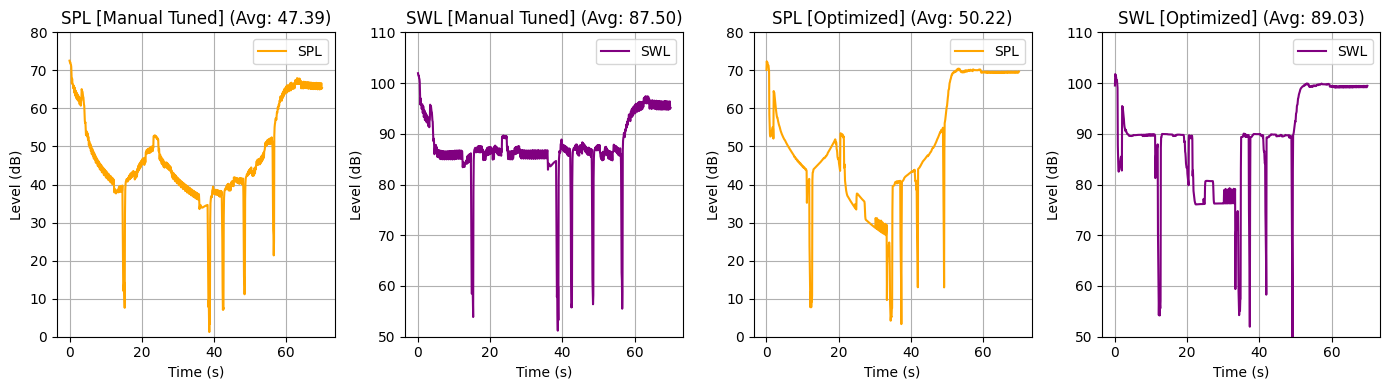

In [ ]:
log_dict = {
    'SPL [Manual Tuned]': {
        'data': np.array(sim_1.spl_history),
        'time': np.array(sim_1.time_history),
        'ylabel': 'Level (dB)',
        'color': 'orange',
        'linestyle': '-',
        'ylim': (0, 80),
        'label': 'SPL',
        'calc_average': True,
        'showgrid': True
    },
    'SWL [Manual Tuned]': {
        'data': np.array(sim_1.swl_history),
        'time': np.array(sim_1.time_history),
        'ylabel': 'Level (dB)',
        'color': 'purple',
        'linestyle': '-',
        'ylim': (50, 110),
        'label': 'SWL',
        'calc_average': True,
        'showgrid': True
    },
    'SPL [Optimized]': {
        'data': np.array(sim_2.spl_history),
        'time': np.array(sim_2.time_history),
        'ylabel': 'Level (dB)',
        'color': 'orange',
        'linestyle': '-',
        'ylim': (0, 80),
        'label': 'SPL',
        'calc_average': True,
        'showgrid': True
    },
    'SWL [Optimized]': {
        'data': np.array(sim_2.swl_history),
        'time': np.array(sim_2.time_history),
        'ylabel': 'Level (dB)',
        'color': 'purple',
        'linestyle': '-',
        'ylim': (50, 110),
        'label': 'SWL',
        'calc_average': True,
        'showgrid': True
    },
}


plotLogData(
    log_dict,
    time = np.array(sim_1.time_history),
    waypoints = waypoints,
    ncols = 4,
)

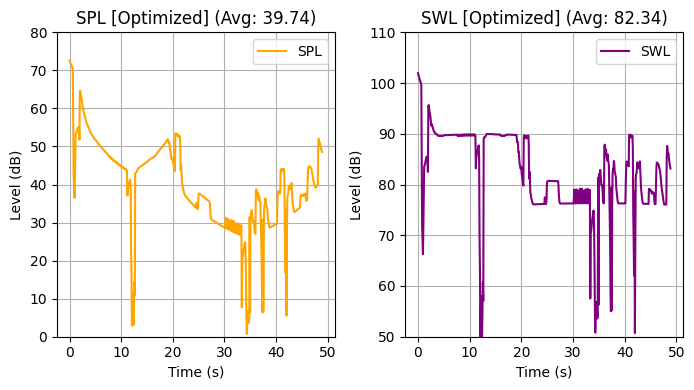

In [46]:
log_dict = {
    'SPL [Optimized]': {
        'data': np.array(sim_2.spl_history),
        'ylabel': 'Level (dB)',
        'color': 'orange',
        'linestyle': '-',
        'ylim': (0, 80),
        'label': 'SPL',
        'calc_average': True,
        'showgrid': True
    },
    'SWL [Optimized]': {
        'data': np.array(sim_2.swl_history),
        'ylabel': 'Level (dB)',
        'color': 'purple',
        'linestyle': '-',
        'ylim': (50, 110),
        'label': 'SWL',
        'calc_average': True,
        'showgrid': True
    },
}


plotLogData(
    log_dict,
    time = np.array(sim_2.time_history),
    waypoints = waypoints,
    ncols = 4,
)

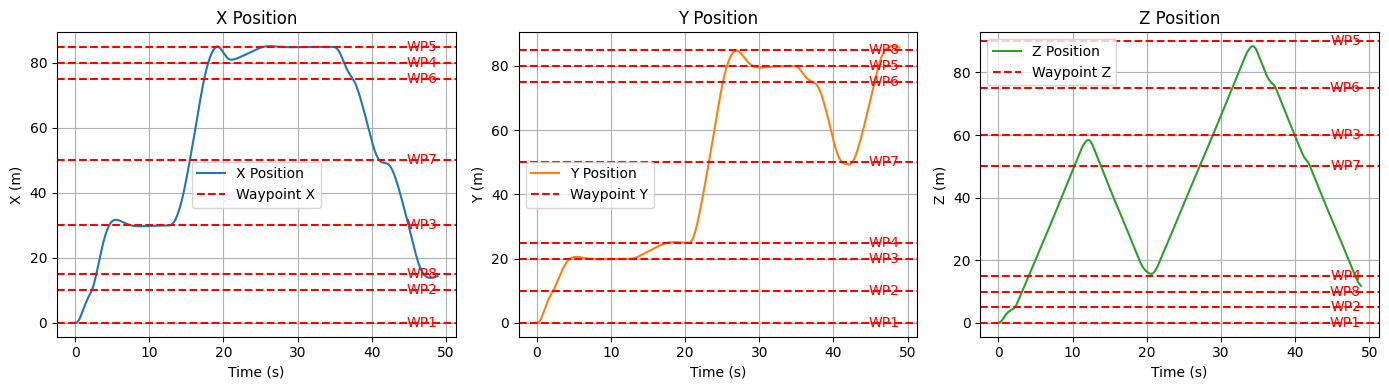

In [30]:
log_dict = {
    'X Position': {
        'data': np.array(sim_2.positions)[:, 0],
        'ylabel': 'X (m)',
        'color': 'tab:blue',
        'linestyle': '-',
        'label': 'X Position',
        'showgrid': True
    },
    'Y Position': {
        'data': np.array(sim_2.positions)[:, 1],
        'ylabel': 'Y (m)',
        'color': 'tab:orange',
        'linestyle': '-',
        'label': 'Y Position',
        'showgrid': True
    },
    'Z Position': {
        'data': np.array(sim_2.positions)[:, 2],
        'ylabel': 'Z (m)',
        'color': 'tab:green',
        'linestyle': '-',
        'label': 'Z Position',
        'showgrid': True
    },
}


plotLogData(
    log_dict,
    time = np.array(sim_2.time_history),
    waypoints = waypoints,
    ncols = 3,
)

In [ ]:
# Plot 3D animation of the drone's trajectory
# plot3DAnimation(sim_1)
# plot3DAnimation(sim_2)

# Plot noise emission map and histogram
plotNoiseEmissionMap(sim_1, upper_limit=None, param='spl', label='Noise Level (dB / s) per second')
plotNoiseEmissionMap(sim_2, upper_limit=None, param='spl', label='Noise Level (dB / s) per second')


plotNoiseEmissionHistogram([sim_1,sim_2], upper_limit=None, param='spl', label='Noise Level (dB / s) per second')

plotLogData(
    generate_log_dict(sim_1),
    time = np.array(sim_1.time_history),
    waypoints = waypoints,
    ncols = 3,
)
plotLogData(
    generate_log_dict(sim_2),
    time = np.array(sim_2.time_history),
    waypoints = waypoints,
    ncols = 3,
)
